# Modifying Transient Land Use Input files for CESM

In [29]:
import netCDF4 as nc4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dateutil.parser
import datetime
import scipy

import xarray as xr

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

In [35]:
# the 16 pft version for useing with FCHIST compset
#datalocation='/eos18/aswann/Macrosystems_ecoclimtel_test/CLM_transient_land_use/'
#transientfilename='landuse.timeseries_0.9x1.25_hist_16pfts_simyr1850-2015_c170428.nc'

# The 78 pft file attempting to use with FCfireHIST compset
datalocation='/home/disk/eos18/aswann/Macrosystems_ecoclimtel_test/CLM_transient_land_use/'
transientfilename='landuse.timeseries_0.9x1.25_hist_78pfts_simyr1850-2015_c170428.nc'

# these are the eventual filenames that we will assign to our custom transient land use files:
Amazon_transient_filename='landuse.timeseries_0.9x1.25_hist_78pfts_simyr1850-2015_c170824_constantAmazonfrom1970.nc'
NAm_transient_filename='landuse.timeseries_0.9x1.25_hist_78pfts_simyr1850-2015_c170824_constantNAmfrom1995.nc'


In [36]:
# open the transient land use file 
ds=xr.open_dataset(datalocation +transientfilename)

In [37]:
# for some reason, these transient land use files don't have values for lsmlat and lsmlon defined 
# we can extract them from the dataset:
lon = ds.LONGXY[0,:].values
lat = ds.LATIXY[:,0].values

# and add them back into the definition of the dimensions
ds_transient=ds.assign_coords(lsmlat = lat, lsmlon = lon)


# create a dataarray of just the PCT_NAT_PFT variable
pct_nat_pft_only = ds_transient.PCT_NAT_PFT

In [38]:
# Identify the initial year where we want to freeze land use

# Amazon freeze year is 1970
AmazonFreezeYear = 1970


# NAm freeze year is 1995
NAmFreezeYear = 1995

In [39]:
# initialize the regionally constant (no land use) transient land use files
ds_transient_Amazon_constant = ds_transient.copy()
ds_transient_NAm_constant = ds_transient.copy()


# initialize the pft only part
Amazon_constant_pft = ds_transient.PCT_NAT_PFT.copy()
NAm_constant_pft = ds_transient.PCT_NAT_PFT.copy()

## Define the "Amazon" region
We are going to stop land use change from happening in one region only  
Define the bounds of that region

#### Amazon
Latitude: -20 to 15  
Longitude: -85 to -35 

In [40]:
Amazon_lat_min = -20
Amazon_lat_max = 15

Amazon_lon_min = 360-85
Amazon_lon_max = 360-35

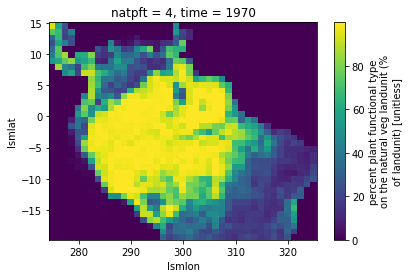

In [41]:
# plot a map of the region in the year that we are going to freeze land use change
ds_transient.PCT_NAT_PFT.sel(time=AmazonFreezeYear,natpft=4,lsmlat=slice(Amazon_lat_min,Amazon_lat_max),
                             lsmlon=slice(Amazon_lon_min,Amazon_lon_max)).plot()

In [42]:
#--- this is the map of land use that we will want to hold fixed for all years after the Freeze Date
constant_Amazon=ds_transient.PCT_NAT_PFT.sel(time=AmazonFreezeYear,lsmlat=slice(Amazon_lat_min,Amazon_lat_max),
                             lsmlon=slice(Amazon_lon_min,Amazon_lon_max))

#constant_Amazon=ds_transient.PCT_NAT_PFT.sel(time=AmazonFreezeYear,natpft=slice(1,9),lsmlat=slice(Amazon_lat_min,Amazon_lat_max),
#                             lsmlon=slice(Amazon_lon_min,Amazon_lon_max))
    


In [43]:
# get the value for the last year in the dataset
lastyear=ds_transient.time[-1]

# assign the land use map that is constant in our focus region from our freeze year into every year after the freeze year
# using .loc and a dict to broadcast our 2D array into the 3D dataset
Amazon_constant_pft.loc[dict(time=slice(AmazonFreezeYear,lastyear),
                                    lsmlat=slice(Amazon_lat_min,Amazon_lat_max), 
                                    lsmlon=slice(Amazon_lon_min,Amazon_lon_max))] = constant_Amazon

#Amazon_constant_pft.loc[dict(time=slice(AmazonFreezeYear,lastyear), natpft=slice(1,9),
#                                    lsmlat=slice(Amazon_lat_min,Amazon_lat_max), 
#                                    lsmlon=slice(Amazon_lon_min,Amazon_lon_max))] = constant_Amazon

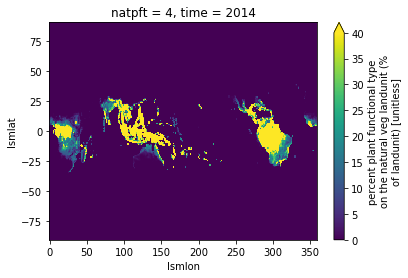

In [44]:
# check it out in a plot
Amazon_constant_pft.sel(time=lastyear-1,natpft=4).plot(vmax=40)

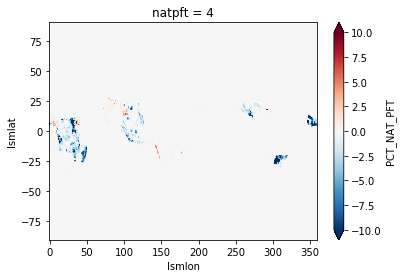

In [45]:
# plot the difference between the last year and the freeze year
(Amazon_constant_pft.sel(time=lastyear-1,natpft=4)-Amazon_constant_pft.sel(time=AmazonFreezeYear,natpft=4)).plot(vmax=10)

In [46]:
# modify our custom copy of the transient land use file to replace the amazon region
ds_transient_Amazon_constant.drop(labels='PCT_NAT_PFT')
ds_transient_Amazon_constant = ds_transient_Amazon_constant.assign(PCT_NAT_PFT=Amazon_constant_pft)

### Check modified land use file against the original

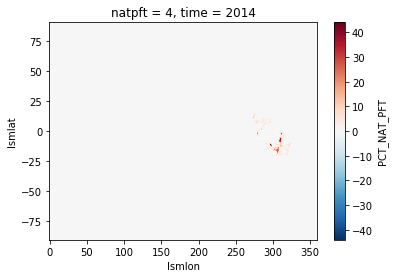

In [47]:
(ds_transient_Amazon_constant.PCT_NAT_PFT.sel(time=lastyear-1,natpft=4) - ds_transient.PCT_NAT_PFT.sel(time=lastyear-1,natpft=4)).plot()

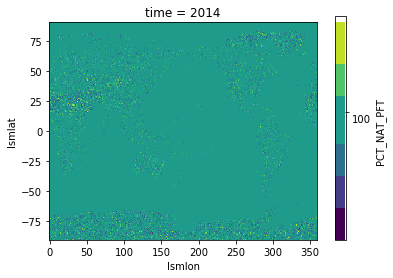

In [48]:
# check to make sure that PFTs sum to 100
ds_transient_Amazon_constant.PCT_NAT_PFT.sel(time=lastyear-1).sum(dim='natpft').plot()

In [49]:
# check to make sure that PFTs sum to 100
ds_transient_Amazon_constant.PCT_NAT_PFT.sum(dim='natpft').max(dim='lsmlat').max(dim='lsmlon').max(dim='time')

<xarray.DataArray 'PCT_NAT_PFT' ()>
array(100.)

### Save the new transient land use file for the Amazon!

In [50]:
# Save the output file
ds_transient_Amazon_constant.to_netcdf(datalocation +Amazon_transient_filename)


## Define the "North America" region
We are going to stop land use change from happening in one region only  
Define the bounds of that region

#### NAm
Latitude: 30 to 64  
Longitude: 220 to 280 

In [18]:
NAm_lat_min = 30
NAm_lat_max = 64

NAm_lon_min = 220
NAm_lon_max = 280

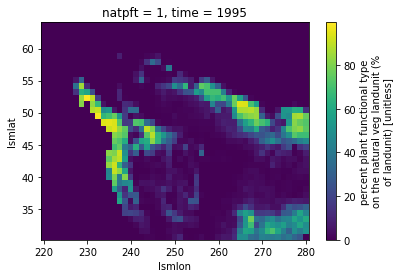

In [19]:
# plot a map of the region in the year that we are going to freeze land use change
ds_transient.PCT_NAT_PFT.sel(time=NAmFreezeYear,natpft=1,lsmlat=slice(NAm_lat_min,NAm_lat_max),
                             lsmlon=slice(NAm_lon_min,NAm_lon_max)).plot()

In [20]:
#--- this is the map of land use that we will want to hold fixed for all years after the Freeze Date
constant_NAm=ds_transient.PCT_NAT_PFT.sel(time=NAmFreezeYear,lsmlat=slice(NAm_lat_min,NAm_lat_max),
                             lsmlon=slice(NAm_lon_min,NAm_lon_max))

In [21]:
# get the value for the last year in the dataset
lastyear=ds_transient.time[-1]

# assign the land use map that is constant in our focus region from our freeze year into every year after the freeze year
# using .loc and a dict to broadcast our 2D array into the 3D dataset
NAm_constant_pft.loc[dict(time=slice(NAmFreezeYear,lastyear), 
                                    lsmlat=slice(NAm_lat_min,NAm_lat_max), 
                                    lsmlon=slice(NAm_lon_min,NAm_lon_max))] = constant_NAm

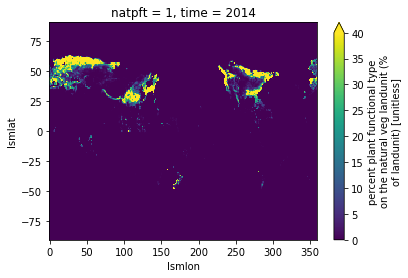

In [22]:
# check it out in a plot
NAm_constant_pft.sel(time=lastyear-1,natpft=1).plot(vmax=40)

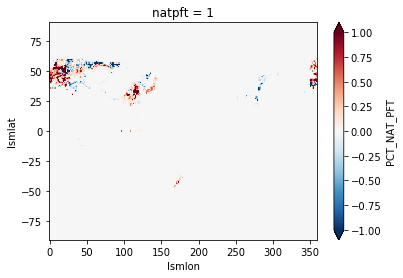

In [23]:
# plot the difference between the last year and the freeze year
(NAm_constant_pft.sel(time=lastyear-1,natpft=1)-NAm_constant_pft.sel(time=NAmFreezeYear,natpft=1)).plot(vmax=1)

In [24]:
# modify our custom copy of the transient land use file to replace the NAm region
ds_transient_NAm_constant.drop(labels='PCT_NAT_PFT')
ds_transient_NAm_constant = ds_transient_NAm_constant.assign(PCT_NAT_PFT=NAm_constant_pft)

### Check the modified file against the original

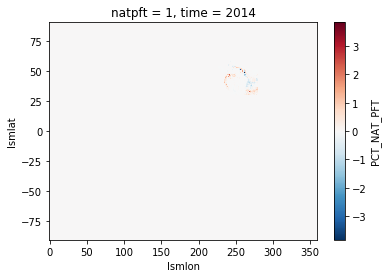

In [25]:
(ds_transient_NAm_constant.PCT_NAT_PFT.sel(time=lastyear-1,natpft=1) - ds_transient.PCT_NAT_PFT.sel(time=lastyear-1,natpft=1)).plot()

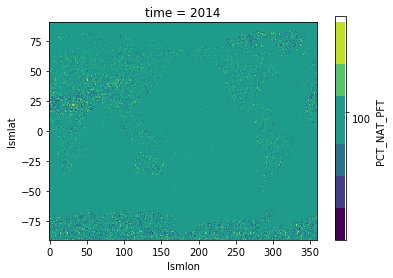

In [26]:
# check to make sure that PFTs sum to 100
ds_transient_NAm_constant.PCT_NAT_PFT.sel(time=lastyear-1).sum(dim='natpft').plot()

In [27]:
# check to make sure that PFTs sum to 100
ds_transient_NAm_constant.PCT_NAT_PFT.sum(dim='natpft').max(dim='lsmlat').max(dim='lsmlon').max(dim='time')

<xarray.DataArray 'PCT_NAT_PFT' ()>
array(100.)

### Save new transient land use file for North America!

In [28]:
# save output
ds_transient_NAm_constant.to_netcdf(datalocation +NAm_transient_filename)

# Stop here! Non-working attempts below

In [92]:
'''
climate_file.loc[dict(time=slice(AmazonFreezeYear,lastyear), natpft=slice(1,9),
                                    lsmlat=slice(Amazon_lat_min,Amazon_lat_max), 
                                    lsmlon=slice(Amazon_lon_min,Amazon_lon_max))] = constant_Amazon
                                    '''

In [47]:
'''# trying with dict
amazon_constant_pft.loc[dict(time=AmazonFreezeYear+1, natpft=slice(1,9),
                                         lsmlat=slice(Amazon_lat_min,Amazon_lat_max), 
                                         lsmlon=slice(Amazon_lon_min,Amazon_lon_max))] = constant_Amazon
                                         '''

ValueError: could not broadcast input array from shape (9,37,41) into shape (9,0,13)

In [76]:
'''npft=np.arange(15)

# trying with dict again
amazon_constant_pft.loc[dict(time=AmazonFreezeYear+1, natpft=npft[(npft>=1) & (npft<=9)],
                             lsmlon=lon[(lon > Amazon_lon_min) & (lon < Amazon_lon_max)],            
                             lsmlat=lat[(lat > Amazon_lat_min) & (lat < Amazon_lat_max)]
                             )] = constant_Amazon
                             '''

TypeError: invalid indexer array, does not have integer dtype: array([-19.31937173, -18.37696335, -17.43455497, -16.4921466 ,
       -15.54973822, -14.60732984, -13.66492147, -12.72251309,
       -11.78010471, -10.83769634,  -9.89528796,  -8.95287958,
        -8.0104712 ,  -7.06806283,  -6.12565445,  -5.18324607,
        -4.2408377 ,  -3.29842932,  -2.35602094,  -1.41361257,
        -0.47120419,   0.47120419,   1.41361257,   2.35602094,
         3.29842932,   4.2408377 ,   5.18324607,   6.12565445,
         7.06806283,   8.0104712 ,   8.95287958,   9.89528796,
        10.83769634,  11.78010471,  12.72251309,  13.66492147,
        14.60732984])

In [62]:
'''mask = (
    (ds_transient.coords["lsmlat"]>=Amazon_lat_min) &
    (ds_transient.coords["lsmlat"]<=Amazon_lat_max) &
    (ds_transient.coords["lsmlon"]<=Amazon_lon_min) &
    (ds_transient.coords["lsmlon"]<=Amazon_lon_max) &
    (ds_transient.coords["natpft"]>=1) &
    (ds_transient.coords["natpft"]<=9) &
    (ds_transient.coords["time"]>AmazonFreezeYear))

temp = ds_transient.copy()
temp["PCT_NAT_PFT"] = xr.where(mask,amazon_constant_pft,temp["PCT_NAT_PFT"])'''

In [62]:
'''
mask = (
   ....:     (ds.coords["lat"] > 20)
   ....:     & (ds.coords["lat"] < 60)
   ....:     & (ds.coords["lon"] > 220)
   ....:     & (ds.coords["lon"] < 260)
   ....: )
   ....: 

In [66]: ds["empty"] = xr.where(mask, 100, ds["empty"])
'''

ValueError: indexes along dimension 'lsmlat' are not equal

In [ ]:
#amazon_constant_pft[120:, 1:9, 60:115,220:260] = climate_file_1970[1:9, 60:115,220:260]

In [ ]:
#amazon_constant_pft[120:, 1:9, 60:115,220:260] = climate_file_1970[1:9, 60:115,220:260]

In [ ]:
#dates_index = np.arange(120,166)

In [ ]:
#amazon_constant_1970_2015 = amazon_constant[dict(time=dates_index)]

In [ ]:
#amazon_constant_1970_2015.to_netcdf('landuse.timeseries_0.9x1.25_hist_78pfts_CMIP6_simyr1970-2015_amazon_constant_c170824.nc')

In [ ]:
'''
Amazon_lat = np.where((ds_transient.lsmlat >= (-20)) & (ds_transient.lsmlat <= 15))
Amazon_lon = np.where((ds_transient.lsmlon >= (360-85)) & (ds_transient.lsmlon <= (360-35)))


#Amazon_lat = np.where((climate_file.lsmlat >= (-20)) & (climate_file.lsmlat <= 15))
#Amazon_lon = np.where((climate_file.lsmlon >= (360-85)) & (climate_file.lsmlon <= (360-35)))

Amazon_lat_min = np.min(Amazon_lat)
Amazon_lat_max = np.max(Amazon_lat)
Amazon_lon_min = np.min(Amazon_lon)
Amazon_lon_max = np.max(Amazon_lon)

#ds_transient.sel(lsmlat=slice(Amazon_lat_min,Amazon_lat_max),lsmlon=slice(Amazon_lon_min,Amazon_lon_max))

'''

In [ ]:
Americas_lat = np.where((climate_file.lsmlat >= 30) & (climate_file.lsmlat <=64))
Americas_lon = np.where((climate_file.lsmlon >= (220)) & (climate_file.lsmlon <= (280)))
   
Americas_lat_min = np.min(Americas_lat)
Americas_lat_max = np.max(Americas_lat)
Americas_lon_min = np.min(Americas_lon)
Americas_lon_max = np.max(Americas_lon)

In [ ]:
north_america_constant_pft[41, 1, 115:160,175:215].plot()

In [ ]:
north_america_constant_pft[145:, 1:9, 115:160,175:215] = climate_file_1995[1:9,115:160,175:215]

In [ ]:
north_america_constant.drop(labels='PCT_NAT_PFT')
north_america_constant = north_america_constant.assign(PCT_NAT_PFT=amazon_constant_pft)

In [ ]:
dates_index = np.arange(145,166)
north_america_constant_1995_2015 = north_america_constant[dict(time=dates_index)]

In [ ]:
north_america_constant_1995_2015.to_netcdf('landuse.timeseries_0.9x1.25_hist_78pfts_CMIP6_simyr1995-2015_north_america_constant_c170824.nc')